In [7]:
import sys
# Add the venv to Python path if needed
venv_path = '/Users/alessandroalberga/Documents/Development/KnowledgeBase/Courses/TheCompleteAgenticAIEngineeringCourse/agents_ed_donner/.venv/lib/python3.12/site-packages'
if venv_path not in sys.path:
    sys.path.insert(0, venv_path)
    
# Verify we can import the modules
try:
    from langgraph.graph import StateGraph, START, END
    print("✓ Successfully imported from langgraph")
except ImportError as e:
    print(f"✗ Failed to import: {e}")
    print(f"Python executable: {sys.executable}")
    print(f"Python version: {sys.version}")

✓ Successfully imported from langgraph


## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [9]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random


In [10]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [11]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [12]:
# Annotated allows you to annotate variables with their descriptions.
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.




### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [13]:

"""
    Definition for the running state model.
"""
class State(BaseModel):
    # Default add_messages reducer.
    messages: Annotated[list, add_messages]


### Step 2: Start the Graph Builder with this State class

In [14]:
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [15]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [16]:
# Acheives START > first_node > END
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

### Step 5: Compile the Graph

In [17]:
graph = graph_builder.compile()

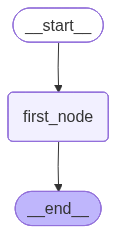

In [ ]:
"""
    Describe the graph using draw_mermaid_png
"""
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [ ]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='228159f8-f921-4d4a-80fc-e25218a66320'), AIMessage(content='Unicorns are smelly', additional_kwargs={}, response_metadata={}, id='ec85b132-d4d7-4e43-88fe-8fa1d3c727c9')]}
{'messages': [HumanMessage(content='reary?', additional_kwargs={}, response_metadata={}, id='477a7a22-b85a-4754-a6ed-cd0f1c8ac0a9'), AIMessage(content='Zombies are smelly', additional_kwargs={}, response_metadata={}, id='30281caf-2df5-4c38-9d7b-f59b4aa8bfee')]}
{'messages': [HumanMessage(content='Oh rearrrrryyyy??', additional_kwargs={}, response_metadata={}, id='931b9bee-77f3-406c-a7aa-6b09594ad66d'), AIMessage(content='Unicorns are moody', additional_kwargs={}, response_metadata={}, id='59435c41-5edf-4544-bd48-e68473b29e70')]}
{'messages': [HumanMessage(content='Fo sho?', additional_kwargs={}, response_metadata={}, id='3733ce50-41dd-4972-a9b5-54e1a9e4bc3c'), AIMessage(content='Toasters are existential', additional_kwargs={}

### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [20]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [21]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)


In [ ]:
# Step 3: Create a Node

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    # Response gets fed into the new state, effectively facilitating chat.
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [ ]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [ ]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [ ]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()